In [47]:
# https://www.kaggle.com/code/nkenyor/twitter-sentiment-analysis/input?select=train.csv

import os
import pandas as pd

csv_path = "../../../DataSetStore/twitter_msg_sentiment_anal/train.csv"

df = pd.read_csv(csv_path)
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [2]:
df['label'].value_counts()

label
0    29720
1     2242
Name: count, dtype: int64

In [3]:
import nltk
import string
import numpy as np

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /home/alex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:

class StrBag:
    def __init__(self,verbose=False):
        self.word_list = []
        self.word_num = []
        self.punctuation = str.maketrans('', '', string.punctuation)
        self.stop_words = set(stopwords.words('english'))
        self.verbose = verbose

    def process_by_word(self,text):

        # casing:-------------------------------------------------------
        str_list = word_tokenize(text)
        str_list = [s.lower() for s in str_list]

        # punctuations:-------------------------------------------------
        str_list = [s.translate(self.punctuation) for s in str_list]

        # stop words and symbols:---------------------------------------
        str_list = [s for s in str_list if s.isalpha()]
        str_list = [s for s in str_list if not s in self.stop_words]

        # saving all words:---------------------------------------------
        self.word_list.extend(str_list)
        self.word_num.append(len(str_list))

        # building text after transform:--------------------------------
        new_text = " ".join(str_list)
        if self.verbose:
            print ("  >>pbw:\n{}\n{}\n".format(text,new_text))
        return new_text
    
    def make_dictionary(self):
        dict = {w: i for i, w in enumerate(set(self.word_list))}
        if self.verbose:
            print ("  >> dictionary: ",dict)
        return dict

    def resize_word_number(self,str):
        max=self.max_min()[0]
        str_list = word_tokenize(str)
        if len(str_list)==0:
            raise Exception("The list has ZERO length")
            
        while len(str_list)<max:
            str_list.extend(str_list)
        
        new_str=" ".join([str_list[j] for j in range(0,max)])
        if self.verbose:
            print ("  >>rwn:\n{}\n{}\n".format(str,new_str))
        return new_str

    def max_min(self):
        return (np.max(self.word_num),np.min(self.word_num))

    def __str__(self):
        return "StrBag [" + " ".join(self.word_list) + "]"


In [5]:
# Copy for processing:-------------------------------------------------------
df_p1 = df.copy()#[0:100]

# Stage 1. Cleaning strings and removing the empty one:-----------------------
bag = StrBag(verbose=False)
df_p1['tweet']=df_p1['tweet'].apply(bag.process_by_word)
df_p1['tweet'].replace('', np.nan, inplace=True)
df_p1.dropna(subset=['tweet'], inplace=True)
print ("  --> 1 Max/Min=",bag.max_min())


# Stage 2. Repeat cleaning strings,building dictionary and resizing length:---
bag = StrBag(verbose=False)
df_p1['tweet']=df_p1['tweet'].apply(bag.process_by_word)
dictionary=bag.make_dictionary()
print ("  --> Dictionary: ",dictionary)
print ("  --> 2 Max/Min=",bag.max_min())
df_p1['tweet']=df_p1['tweet'].apply(bag.resize_word_number)


DICT_LENGTH= len(dictionary)
EMBD_SIZE = 5


  --> 1 Max/Min= (37, 0)
  --> Dictionary:  {'sandals': 0, 'ddd': 1, 'coolwallet': 2, 'juve': 3, 'champers': 4, 'cornered': 5, 'harummanis': 6, 'dis': 7, 'use': 8, 'lovelyweekend': 9, 'transsexy': 10, 'instame': 11, 'russiafans': 12, 'dividends': 13, 'impo': 14, 'symantec': 15, 'ibizalifestyle': 16, 'andy': 17, 'booking': 18, 'keeponkeepingon': 19, 'kentstate': 20, 'purposefully': 21, 'cosy': 22, 'mystarsdeserveallthehappiness': 23, 'girlfriendpoints': 24, 'disbelief': 25, 'discouraged': 26, 'moda': 27, 'joanferguson': 28, 'orwellian': 29, 'loooooong': 30, 'stbstage': 31, 'math': 32, 'myfavoriteplace': 33, 'musicians': 34, 'laplaya': 35, 'modiinus': 36, 'illmissyou': 37, 'iii': 38, 'pinkface': 39, 'mebeforeyou': 40, 'atpeace': 41, 'nickel': 42, 'ronery': 43, 'texastohawaii': 44, 'sprucemeadows': 45, 'ilove': 46, 'exaggeration': 47, 'bbbchallenge': 48, 'pleasedontrain': 49, 'healthystyle': 50, 'imprisoned': 51, 'escapesitters': 52, 'petsofinstagram': 53, 'jointhecircle': 54, 'whatz': 55

In [6]:
import gc
import math
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F


torch.manual_seed(1988)

class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, text_list, label_list, dictionary):
        self.text_list = text_list
        self.label_list = label_list
        self.dictionary = dictionary
        self.embedding = nn.Embedding(DICT_LENGTH, EMBD_SIZE)

    def encode(self, text):
        output = []
        for word in word_tokenize(text):
            word_key = dictionary[word]
            word_key = torch.tensor([word_key], dtype=torch.long)
            word_embedding = self.embedding(word_key)
            word_embedding = torch.squeeze(input=word_embedding)
            output.append(word_embedding)
        return np.array(output)
    
    def __len__(self):
        return len(self.text_list)
    
    def __getitem__(self, index):
        with torch.no_grad():
            encoded_text = self.encode(self.text_list[index])
            x,y=torch.from_numpy(encoded_text), torch.tensor([self.label_list[index]],dtype=torch.float)
            # print(x.shape, y.shape)
        return x,y


In [7]:
train_dataset = MyDataset(text_list=df_p1['tweet'].values,
                          label_list=df_p1['label'].values,
                          dictionary=dictionary)
# print (data_set[0])
# print (len(train_dataset))
# print (train_dataset.text_list)

In [8]:

def execute (runnable):
    if torch.cuda.device_count()>0:
        print ("  --> Let's work with cuda")
        device = torch.device("cuda:0")
        gc.collect()
        torch.cuda.empty_cache()
        if runnable is not None:
            with torch.cuda.device(0):
                return runnable(device)
        return device
    else:
        print ("  --> Let's work with CPU")
        device = torch.device("cpu")
        if runnable is not None:
            return runnable(device)
        return device

for x in range (3):
    execute(None)

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    print ("  --> Copied data: ",data.shape)
    return data.to(device, non_blocking=True)

def load_to_device(loader,device):
    load_list=[]
    for i, data in enumerate(loader):
        load_list.append((to_device(data[0],device), to_device(data[1],device)))
    return load_list

BATCH_SIZE = 1000

train_set_loader = torch.utils.data.DataLoader(
        train_dataset,batch_size=BATCH_SIZE,shuffle=True)

train_list = load_to_device(train_set_loader,execute(None))


  --> Let's work with cuda
  --> Let's work with cuda
  --> Let's work with cuda
  --> Let's work with cuda
  --> Copied data:  torch.Size([1000, 37, 5])
  --> Copied data:  torch.Size([1000, 1])
  --> Copied data:  torch.Size([1000, 37, 5])
  --> Copied data:  torch.Size([1000, 1])
  --> Copied data:  torch.Size([1000, 37, 5])
  --> Copied data:  torch.Size([1000, 1])
  --> Copied data:  torch.Size([1000, 37, 5])
  --> Copied data:  torch.Size([1000, 1])
  --> Copied data:  torch.Size([1000, 37, 5])
  --> Copied data:  torch.Size([1000, 1])
  --> Copied data:  torch.Size([1000, 37, 5])
  --> Copied data:  torch.Size([1000, 1])
  --> Copied data:  torch.Size([1000, 37, 5])
  --> Copied data:  torch.Size([1000, 1])
  --> Copied data:  torch.Size([1000, 37, 5])
  --> Copied data:  torch.Size([1000, 1])
  --> Copied data:  torch.Size([1000, 37, 5])
  --> Copied data:  torch.Size([1000, 1])
  --> Copied data:  torch.Size([1000, 37, 5])
  --> Copied data:  torch.Size([1000, 1])
  --> Copied

In [27]:
# input_size – The number of expected features in the input x

# hidden_size – The number of features in the hidden state h

# num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two RNNs together to form a stacked RNN, with the second RNN taking in outputs of the first RNN and computing the final results. Default: 1

# nonlinearity – The non-linearity to use. Can be either 'tanh' or 'relu'. Default: 'tanh'

# bias – If False, then the layer does not use bias weights b_ih and b_hh. Default: True

# batch_first – If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature).
#  Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: False

# dropout – If non-zero, introduces a Dropout layer on the outputs of each RNN layer except the last layer,
#  with dropout probability equal to dropout. Default: 0

# bidirectional – If True, becomes a bidirectional RNN. Default: False


class Rnn(nn.Module) :
    def __init__(self, embedding_dim, hidden_dim,rnn_layer_num) :
        super(Rnn,self).__init__()
        self.rnn = nn.RNN(input_size=embedding_dim,
                          hidden_size=hidden_dim,
                          num_layers=rnn_layer_num,
                          batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.rnn_layer_num = rnn_layer_num
        
    def forward(self, x):
        #print("X - shape: ",x.shape)
        rnn_out, hn = self.rnn(x)
        hn = hn[self.rnn_layer_num-1]
        #print("R - shape: {},{}".format(rnn_out.shape,hn.shape))
        y = self.linear(hn)
        #print ("Y - shape: ",y.shape)
        return y


In [40]:
rnn_init = Rnn(EMBD_SIZE, 100, 3).to(execute(None))
#optimizer = torch.optim.Adam(rnn_init.parameters(), lr=0.001)
optimizer = torch.optim.SGD(rnn_init.parameters(), lr=0.04,momentum=0.01)
criteria = nn.MSELoss()

  --> Let's work with cuda


In [41]:

def adapt_perceptron (device):
    
    epoch_max_num = 100000
    max_test_tp=0
    history=[]
    
    for epoch_num in range(epoch_max_num):
        
        running_loss = 0.0
        for train_batch in train_list:
            x_train, y_train = train_batch[0], train_batch[1]
            optimizer.zero_grad()
            y_pred = rnn_init(x_train)
            loss = criteria(y_pred, y_train)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            break

        if epoch_num % 1000 == 0:
            print("Epoch [{}/{}] loss: {}".format(epoch_num,epoch_max_num,running_loss))
            
        history.append((epoch_num,running_loss))
        #break
            
    print('Adapting is finished!')
    return history

In [42]:
train_history = execute(runnable=adapt_perceptron)

  --> Let's work with cuda
Epoch [0/100000] loss: 0.07084251195192337
Epoch [1000/100000] loss: 0.061618879437446594
Epoch [2000/100000] loss: 0.06056009232997894
Epoch [3000/100000] loss: 0.059327222406864166
Epoch [4000/100000] loss: 0.05731611326336861
Epoch [5000/100000] loss: 0.05144505575299263
Epoch [6000/100000] loss: 0.03257139399647713
Epoch [7000/100000] loss: 0.016966931521892548
Epoch [8000/100000] loss: 0.0062666540034115314
Epoch [9000/100000] loss: 0.003518577665090561
Epoch [10000/100000] loss: 0.0013793030520901084
Epoch [11000/100000] loss: 0.0006701626116409898
Epoch [12000/100000] loss: 0.0003782842250075191
Epoch [13000/100000] loss: 0.00019521931244526058
Epoch [14000/100000] loss: 0.0001078272980521433
Epoch [15000/100000] loss: 9.065994527190924e-05
Epoch [16000/100000] loss: 4.442210411070846e-05
Epoch [17000/100000] loss: 5.106964090373367e-05
Epoch [18000/100000] loss: 2.7922773369937204e-05
Epoch [19000/100000] loss: 1.8865108359022997e-05
Epoch [20000/1000

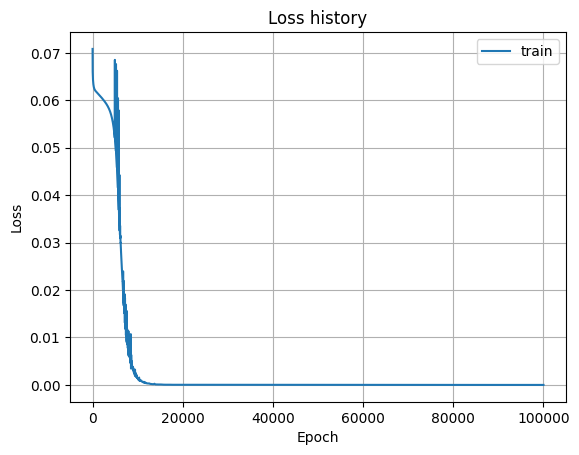

In [45]:
import matplotlib.pyplot as plt

loss=[h[1] for h in train_history]

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(loss, label='train')
plt.legend();